# Lab 6 - Confidence Intervals
#### Aidan Berres
#### Physics 434
#### 11/22/20

In [84]:
from pyuvdata import UVData
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from scipy import stats

In [2]:
uv = UVData()
uv.read('hera1.hd5',file_type='uvh5')

## Problem 1
Here we are taking the data from all the baselines for a specific time, which gives us enough data to formulate a background. For this I am choosing the data at time = 0.

In [4]:
ma=np.array([])
#mask=np.ma.masked_where(freqs<60,freqs)
for i in range(len(p)):
    ria=abs(uv.get_data(p[i]))
    ria=ria[0]
    #ria=np.ma.masked_where(freqs<60,ria)
    ma=np.append(ma,ria)

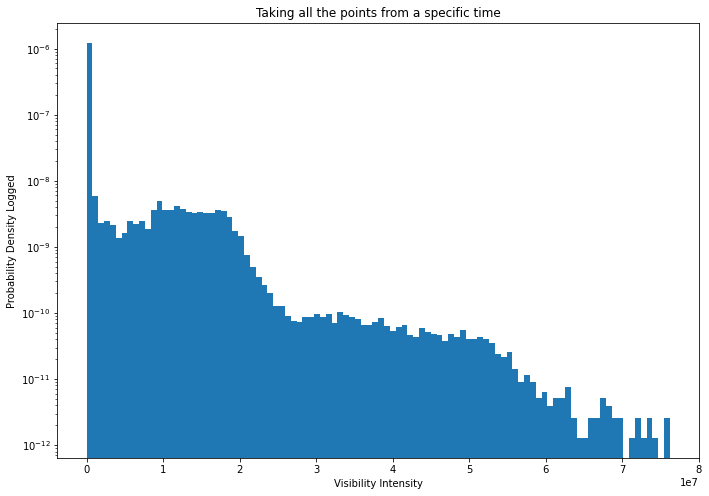

In [197]:
#Aud's Method
fig,ax=plt.subplots(figsize=(11.5,8))
plt.title('Taking all the points from a specific time')
plt.yscale('log')
plt.xlabel('Visibility Intensity')
plt.ylabel('Probability Density Logged')
plt.hist(ma,bins=100,density=True);

This background distribution seems to be unidentifiable in terms of fitting it to a specific pdf function. We need to take a slice of this full distribution if we are going to fit a pdf to it. Here we are averaging all the baselines and plotting the average baseline with visibility vs. Frequency. This is to find where our main background lies within the data.

In [6]:
bt = []
for i in range(666):
    d = abs(uv.get_data(p[i]))
    bt.append(d[0])

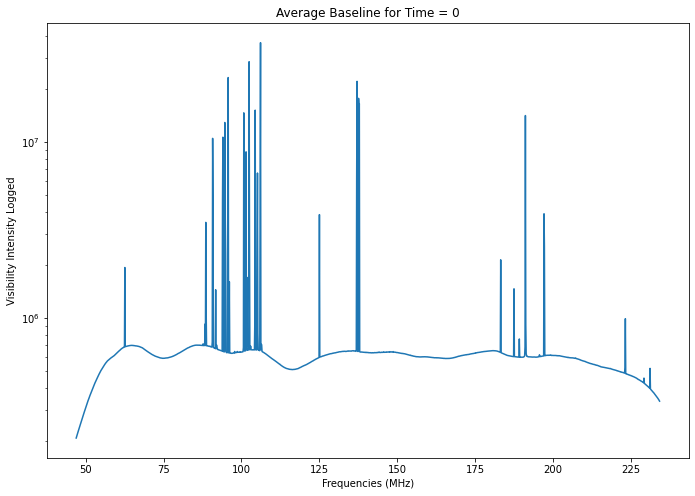

In [173]:
fig,ax=plt.subplots(figsize=(11.5,8))
bt = np.array(bt)
mc=bt.mean(axis=0)
plt.yscale('log')
plt.title('Average Baseline for Time = 0')
plt.xlabel('Frequencies (MHz)')
plt.ylabel('Visibility Intensity Logged')
plt.plot(freqs,mc);

We can see here that most of the signals do not lie below 6 magnitudes (10^6), thus if we are looking for signal-free data, we can just use the values below 6 magnitudes. Thus we take a slice of the data and attempt to fit a pdf to the function. Since we are logging our histogram values we can choose to fit a lognormal pdf to it.  

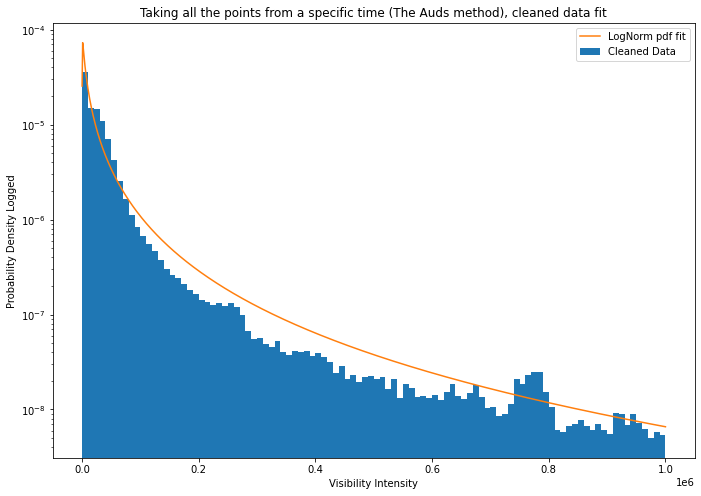

In [174]:
#Aud's Method
fig,ax=plt.subplots(figsize=(11.5,8))
plt.title('Taking all the points from a specific time (The Auds method), cleaned data fit')
plt.yscale('log')
plt.xlabel('Visibility Intensity')
plt.ylabel('Probability Density Logged')
max_maria=1e6
maria=ma
masha= np.linspace(0,max_maria,1000)
maria_sub= maria[abs(maria)<max_maria]
sig,one,two=stats.lognorm.fit(maria_sub)
plt.hist(maria_sub,bins=100,density=True,label="Cleaned Data");
plt.plot(masha,stats.lognorm.pdf(masha,s=sig,loc=one,scale=two),label='LogNorm pdf fit')
plt.legend(loc=0);

Thus we find the pdf of our background using `stats.LogNorm.fit()` which returns three parameter values, which are the sigma curvature value for the Log normal pdf, the location (or $\mu$) of the distribution, and the scale of the distribution.

In [39]:
siggy5=stats.norm.cdf(5)

In [40]:
stats.lognorm.ppf(siggy5,s=sig,loc=one,scale=two)

42970588.40081523

This is our 5-sigma location for this pdf. This corresponds to a value of 4.29e8 intensity in the visiblities.

## Problem 2
Here we are injecting some signals, 20 sigma away from our background distirbution. We can use the 5-sigma value from before to obtain a general sigma distance number.

## 2. a)
Here we are generating our signal by taking samples of the original dataset and shifting the values by the 20 sigma distance specified before. We are taking about 25% of the data values using the mask boolean function seen in my code. 

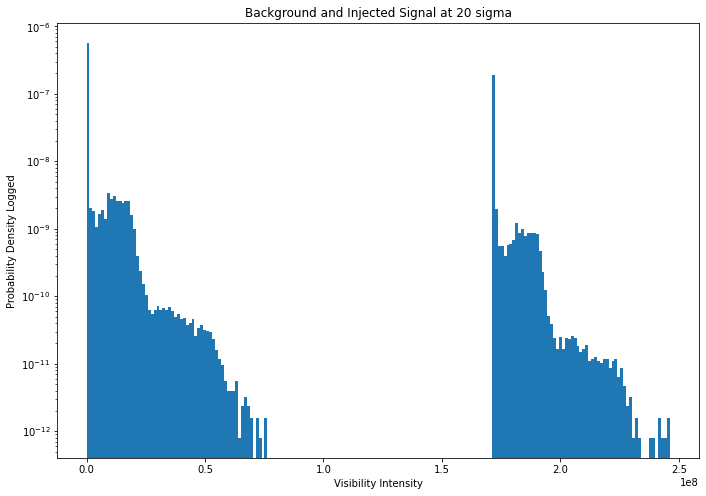

In [199]:
sha = (np.random.rand(ma.size) < 0.25)*42970588.40081523*(20/5)
fig,ax=plt.subplots(figsize=(11.5,8))
plt.yscale('log')
plt.xlabel('Visibility Intensity')
plt.ylabel('Probability Density Logged')
plt.title('Background and Injected Signal at 20 sigma')
jinji=ma+sha
plt.hist(jinji,bins=200,density=True);

## 2. b)
It is not symmetric since the original distribution is since it is a lognormal distribution, so it is biased for values greater than 0, or in this case, greater than our x-sigma location.

## Problem 3
I am simulating a suite of injected signals in the range from zero sigma to about 30 sigma. I am creating 500 injected signals in this range. This is using the same process as in problem 2. Since there will be many data points in play here, I need to take a subset of my data in which I am naming `maria`. This will consist of 50,000 randomly chosen data points from the original data distribution `ma`. You can see my process below. 

In [13]:
maria= np.random.choice(ma,size=50_000)

In [70]:
signal_strengths = np.linspace(0, 30*42970588/5,500)
sha = (np.random.rand(500,maria.size) < 0.25)#*42970588.40081523*(1/5)

In [71]:
_, signal_strengths_grid = np.meshgrid(sha[0, :], signal_strengths)
signal = sha * signal_strengths_grid

In [72]:
obs = signal+maria

## 3. a)
Here is my 2D histogram of the Injected Signals vs. the Observed data,

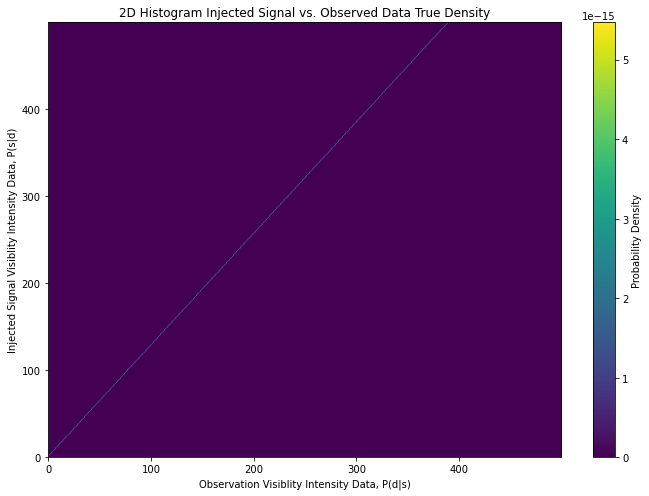

In [179]:
fig,ax=plt.subplots(figsize=(11.5,8))
Psd, temp, temp2=np.histogram2d(obs.flatten(), signal_strengths_grid.flatten(), bins=500, density=True)
plt.imshow(Psd.T,origin='bottom')
#plt.yscale('log')
plt.gca().set_aspect('auto')
plt.colorbar(label='Probability Density')
plt.title('2D Histogram Injected Signal vs. Observed Data True Density')
plt.xlabel('Observation Visiblity Intensity Data, P(d|s)')
plt.ylabel('Injected Signal Visiblity Intensity Data, P(s|d)');

This 2D histogram seems to be missing some values due to the colormap being taken over the whole set of data values. We can fix this problem by shifting cmap down so we can see more signals. 

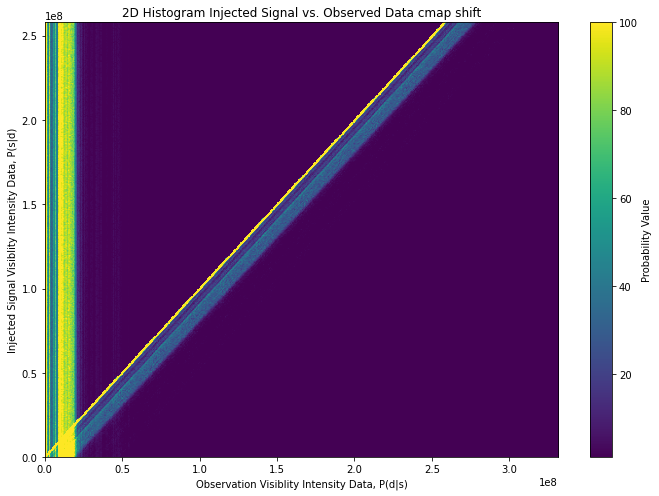

In [180]:
fig,ax=plt.subplots(figsize=(11.5,8))
Psd, temp, temp2=np.histogram2d(obs.flatten(), signal_strengths_grid.flatten(), bins=500)
plt.imshow(Psd.T,origin='bottom',extent=(0, obs.max(), signal_strengths.min(), signal_strengths.max()),vmin=1,vmax=100)
#plt.yscale('log')
plt.gca().set_aspect('auto')
plt.colorbar(label='Probability Value')
plt.title('2D Histogram Injected Signal vs. Observed Data cmap shift')
plt.xlabel('Observation Visiblity Intensity Data, P(d|s)')
plt.ylabel('Injected Signal Visiblity Intensity Data, P(s|d)');

This is much better, but we can do a lot better, we can make the colormap logged. This will have to be done by adding 1 to the plot so we can use the logarithmic functions since it cannot a zero value.

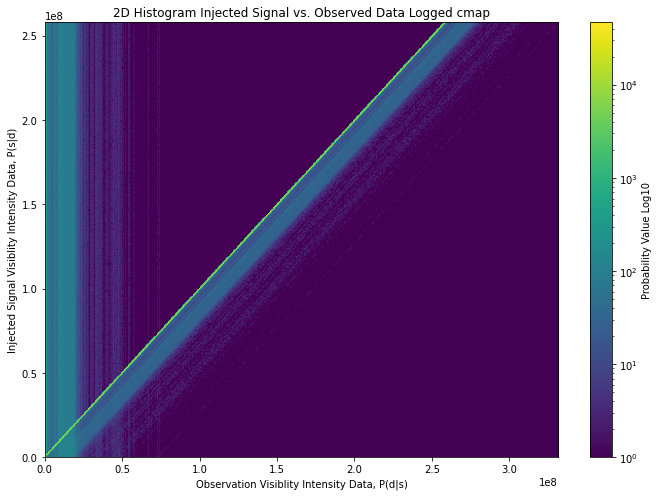

In [181]:
fig,ax=plt.subplots(figsize=(11.5,8))
Psd, temp, temp2=np.histogram2d(obs.flatten(), signal_strengths_grid.flatten(), bins=500)
plt.imshow(Psd.T+1,origin='bottom',extent=(0, obs.max(), signal_strengths.min(), signal_strengths.max()),norm=colors.LogNorm(vmin=1,vmax=Psd.max(),clip=True))
#plt.yscale('log')
plt.gca().set_aspect('auto')
plt.colorbar(label='Probability Value Log10')
plt.title('2D Histogram Injected Signal vs. Observed Data Logged cmap')
plt.xlabel('Observation Visiblity Intensity Data, P(d|s)')
plt.ylabel('Injected Signal Visiblity Intensity Data, P(s|d)');

## 3. b)

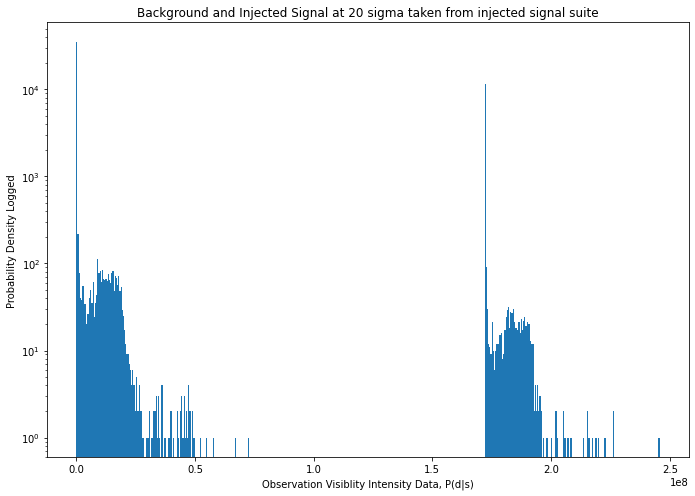

In [184]:
index = abs(signal_strengths - 42970588.40081523*(20/5)).argmin()
vals = obs[index, :]
fig,ax=plt.subplots(figsize=(11.5,8))
plt.yscale('log')
plt.xlabel('Observation Visiblity Intensity Data, P(d|s)')
plt.ylabel('Probability Density Logged')
plt.title('Background and Injected Signal at 20 sigma taken from injected signal suite')
plt.hist(vals,bins=500);

We see here that it emulates the previous plot fairly well. Since we are taking a subset of the data it will not reflect the whole dataset from the previous plot, but we see that the background and the signal are in the same general location and with the same general shape as before.
## 3. c)

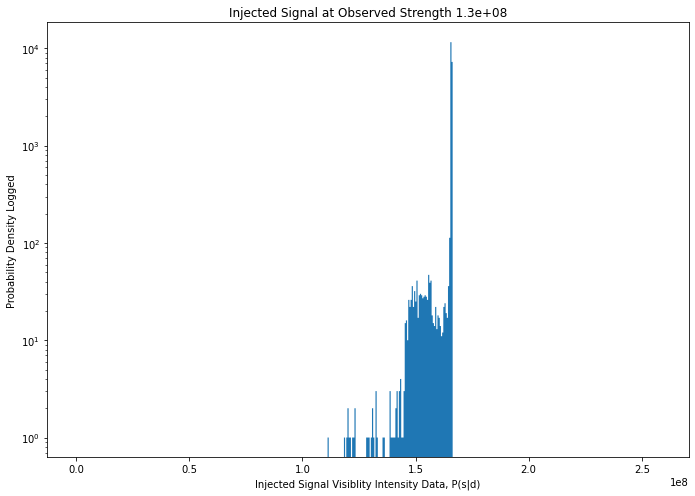

In [194]:
mach=signal_strengths[250]
fig,ax=plt.subplots(figsize=(11.5,8))
ex2=np.linspace(signal_strengths.min(), signal_strengths.max(),500)
plt.yscale('log')
plt.xlabel('Injected Signal Visiblity Intensity Data, P(s|d)')
plt.ylabel('Probability Density Logged')
plt.title(f'Injected Signal at Observed Strength {mach:0.1e}')
plt.fill_between(ex2,Psd[250],step="pre");
#plt.hist(Psd[250],bins=500);

The meaning of this histogram is that given the observed strength 1.3e8, what is the probability of there being an injected signal. We find here that such probability. 

## 3. d)

Here we are finding the 1 sigma uncertainty of this given probability distribution. We can do this by integrating up to -1 sigma from a normal distribution and then select the greatest fit probability value from this integration, which is the best estimate to a 1-sigma value for this distribution.

In [171]:
mp = Psd[250]
bins = np.linspace(signal_strengths.min(), signal_strengths.max(),50_000)

partial_sums = np.cumsum(mp) / np.sum(mp)
index = np.argmin(abs(partial_sums - stats.norm.cdf(-1)))
mariaiscool=bins[index - 1]

print(mariaiscool - bins[np.argmax(mp)])

-10313.147382947616


Here we find that our our 1 sigma uncertainty is around -10313 which makes sense since our distribution is moslty focused in the negative direction (the other values are all less than the mode).
## 3. e)
This value is not symmetric, as stated before, this value is negative since our distribution is not symmetric, but has values that point in the negative direction. It is biased since it is coming from a biased signal distribution. This tells us that our true signal is less than our best estimate that we have found.

~~For the record, I could have named my variables after seinfeld characters~~